In [394]:
!pip install torchinfo

In [395]:
import torch
from torch import nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset, random_split
from torch.optim import Adam, RMSprop
from torchinfo import summary
from torchvision import models 

import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
import os
from PIL import Image
import numpy as np

In [396]:
import kagglehub

path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celeba-dataset


In [397]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [398]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [399]:
device

'cuda'

In [400]:
common_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor()
])


In [401]:
link = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"
dataframe = pd.read_csv(link)

In [402]:
dataframe.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [403]:
dataframe = dataframe.drop(["5_o_Clock_Shadow", "Arched_Eyebrows", "Blurry", "Bushy_Eyebrows", "Chubby", "Goatee", "Heavy_Makeup", "Sideburns"], axis="columns")

In [404]:
dataframe.columns

Index(['image_id', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs',
       'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair',
       'Double_Chin', 'Eyeglasses', 'Gray_Hair', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [405]:
class CustomDataset(Dataset):
    def __init__(self, data_file, data_dir, device, image_transformer=None):

        self.data = data_file
        self.columns = self.data.columns
        self.data_list = list(self.data[self.columns[0]])
        self.data_dir = data_dir
        self.device = device

        self.image_transformer = image_transformer


    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        img = os.path.join(self.data_dir, self.data_list[idx])
        img = Image.open(img).convert("RGB")
        if self.image_transformer is not None:
            img = self.image_transformer(img)

        vector = self.data.iloc[idx, 1:]
        vector = (vector + 1) / 2
        vector = torch.tensor(vector, dtype=torch.float32).to(self.device)


        return img, vector

In [406]:
data_file = dataframe
data_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"

dataset = CustomDataset(data_file, data_dir, device, image_transformer=common_transform)

In [407]:
print(len(dataset))

202599


In [408]:
train_data, val_data, test_data = random_split(dataset, [0.8, 0.1, 0.1])

In [409]:
train_data, _ = random_split(train_data, [0.5, 0.5])

In [410]:
print(len(train_data), len(val_data), len(test_data))

81040 20260 20259


In [411]:
def output(data, limit):
    for i, (x, y) in enumerate(data):
        x = x.permute(1, 2, 0).detach().cpu().numpy()

        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(x)

        print(y)



        plt.show()


        if i+1 >= limit:
            break


tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


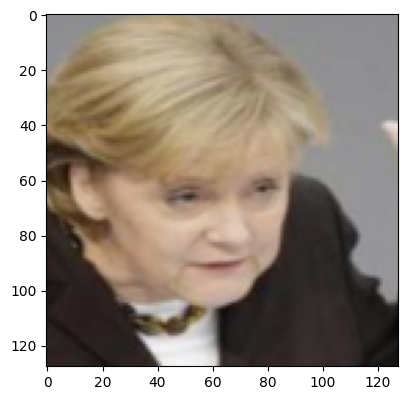

In [412]:
output(train_data, 1)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.],
       device='cuda:0')


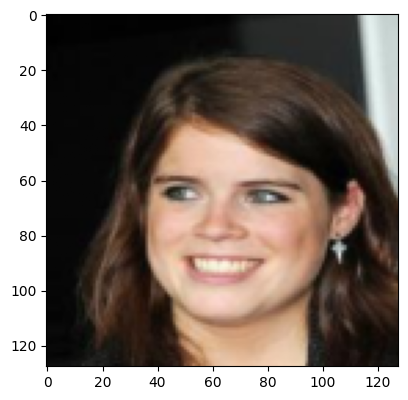

In [413]:
output(val_data, 1)

tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


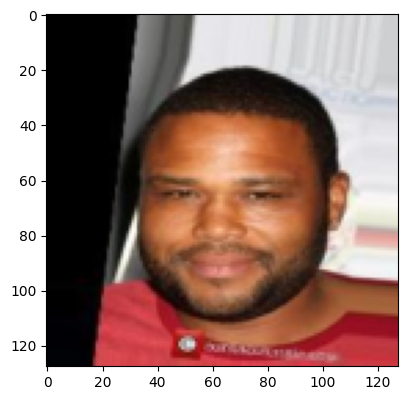

In [414]:
output(test_data, 1)

In [415]:
batch_size = 32

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [416]:
x, y = next(iter(train_dl))
print(x.shape, y.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32, 32])


In [417]:
x, y = test_data[0]
y

tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')

In [418]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                             kernel_size=kernel_size, stride=stride, padding=padding)
        self.bnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return F.leaky_relu(self.bnorm(self.conv(x)))

# --------------------------------------------------------------------------------------------------------------------

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output=False):
        super().__init__()

        self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                             kernel_size=kernel_size, stride=stride, padding=padding)
        self.bnorm = nn.BatchNorm2d(out_channels)

        self.output = output

    def forward(self, x):
        if self.output == False:
            return F.leaky_relu(self.bnorm(self.conv(x)))
        elif self.output == True:
            return torch.sigmoid(self.bnorm(self.conv(x)))


# --------------------------------------------------------------------------------------------------------------------
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding)

        self.bnorm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3,
                               stride=1, padding=1)

        self.bnorm2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels or stride != 1:
            self.add_conv = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                          stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels)
            )

        else:
            self.add_conv = nn.Identity()

    def forward(self, x):
        out = self.bnorm1(self.conv1(x))
        add_out = self.add_conv(x)

        out = F.leaky_relu(out)

        out = self.bnorm2(self.conv2(out))

        # if add_out is not None:
        out += add_out
        out = F.leaky_relu(out)

        return out

# --------------------------------------------------------------------------------------------------------------------

class UpResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.up_conv1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                           kernel_size=kernel_size, stride=stride, padding=padding)
        self.bnorm1 = nn.BatchNorm2d(out_channels)

        self.up_conv2 = nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                                           kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels or stride != 1:

            self.add_conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                   kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels)

            )
        else:
            self.add_conv = nn.Identity()

    def forward(self, x):
        out = self.bnorm1(self.up_conv1(x))
        add_out = self.add_conv(x)

        out = F.leaky_relu(out)

        out = self.bnorm2(self.up_conv2(out))

        out += add_out

        out = F.leaky_relu(out)

        return out

In [419]:
class SEBlock(nn.Module):
  def __init__(self, C, r=16):
    super().__init__()

    self.aap = nn.AdaptiveAvgPool2d((1, 1))
    self.flatten = nn.Flatten()

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

    self.linear1 = nn.Linear(C, C//r)
    self.linear2 = nn.Linear(C//r, C)


  def forward(self, x):
    out = self.aap(x)
    out = self.flatten(out)

    out = self.relu(self.linear1(out))
    out = self.sigmoid(self.linear2(out))

    out = out[:, :, None, None]

    res = x * out

    return res

In [420]:
tensor = torch.randn(1, 512, 2, 2)
block = SEBlock(512)

out = block(tensor)
out.shape

torch.Size([1, 512, 2, 2])

In [421]:
# --------------------------------------------------------------------------------------------------------------------


class Encoder(nn.Module):
    def __init__(self, cond=32, latent_dim=128):
        super().__init__()

        self.conv1 = ConvBlock(3, 64, 4, 2, 1)

        self.conv2 = ResBlock(64, 64, 4, 2, 1)

        self.conv3 = ConvBlock(64, 128, 4, 2, 1)

        self.conv4 = ResBlock(128, 128, 4, 2, 1)

        self.conv5 = ConvBlock(128, 256, 4, 2, 1)

        self.conv6 = ConvBlock(256, 512, 4, 2, 1)

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(512 * 2 * 2 + cond, 1024)

        self.linear2_mu = nn.Linear(1024, latent_dim)

        self.linear2_logvar = nn.Linear(1024, latent_dim)

    def forward(self, x, y):
        out = self.conv1(x)
        # print(x.shape)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)

        out = self.flatten(out)

        out = torch.cat((out, y), dim=1)

        h = F.leaky_relu(self.linear1(out))
        # h = F.leaky_relu(self.linear2(out))

        mu = self.linear2_mu(h)
        logvar = self.linear2_logvar(h)
        return mu, logvar

In [422]:
encoder = Encoder()
tensor1 = torch.randn(1, 3, 128, 128)
tensor2 = torch.randn(1, 32)

mu, logvar = encoder(tensor1, tensor2)
print(mu.shape, logvar.shape)

torch.Size([1, 128]) torch.Size([1, 128])


In [423]:
# --------------------------------------------------------------------------------------------------------------------


class Decoder(nn.Module):
    def __init__(self, cond=32, latent_dim=128):
        super().__init__()

        self.linear1 = nn.Linear(latent_dim + cond, 1024)
        self.linear2 = nn.Linear(1024, 512 * 2 * 2)
        # x.view(256, 7, 7)
        self.unflatten = nn.Unflatten(1, (512, 2, 2))


        self.t_conv1 = UpResBlock(512, 256, 4, 2, 1)
        self.se_block1 = SEBlock(256)

        self.t_conv2 = UpResBlock(256, 128, 4, 2, 1)
        self.se_block2 = SEBlock(128)

        self.t_conv3 = UpConvBlock(128, 64, 4, 2, 1)
        # self.se_block3 = SEBlock(64)

        self.t_conv4 = UpConvBlock(64, 64, 4, 2, 1)

        self.t_conv5 = UpConvBlock(64, 32, 4, 2, 1)
        # 32, 64, 64
        self.t_conv6 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        # 3, 128, 128

        # self.upsmaple1 = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)

        out = F.leaky_relu(self.linear1(zy))
        out = F.leaky_relu(self.linear2(out))

        out = self.unflatten(out)
        out = self.t_conv1(out)
        out = self.se_block1(out)

        out = self.t_conv2(out)
        out = self.se_block2(out)

        out = self.t_conv3(out)
        # out = self.se_block3(out)

        out = self.t_conv4(out)

        out = self.t_conv5(out)

        rec = F.sigmoid(self.t_conv6(out))

        return rec


In [424]:
# --------------------------------------------------------------------------------------------------------------------


class VAE(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        # z = μ+σ*ε
        z = mu + std * eps
        return z

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparametrize(mu, logvar)
        rec = self.decoder(z, y)
        return rec, mu, logvar

    def predict(self, x, y):
        self.eval()

        with torch.no_grad():
            if len(x.shape) < 4:
                x = x.unsqueeze(0)
            out, mu, logvar = self.forward(x, y)

            # if len(out.shape) == 3:
            # out = out.squeeze(0)
            out = out.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            #     out = out.squeeze(0)
            # out = out.view(-1, 28, 28)

        return out

    def sample(self, z, y):
        self.eval()

        with torch.no_grad():
            out = self.decoder(z, y)
        out = out.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        return out


In [425]:
model = VAE()
tensor1 = torch.rand(1, 3, 128, 128)
tensor2 = torch.rand(1, 32)

res = model.predict(tensor1, tensor2)
print(res.shape)

(128, 128, 3)


In [426]:
model = VAE()
tensor1 = torch.rand(1, 128)
tensor2 = torch.rand(1, 32)

res = model.sample(tensor1, tensor2)
print(res.shape)

(128, 128, 3)


In [427]:
# def loss_function(recon_x, x, mu, logvar, epoch):
#     recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # or BCE, if normilized in range [0,1]
#     kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL-divergention
#     kl_weight = float(1 / (1 + np.exp(-0.1 * (epoch - 5))))

#     return recon_loss + kl_loss * kl_weight


In [428]:
class VGG(nn.Module):
    def __init__(self, layer_index=16):
        super().__init__()

        vgg = models.vgg19(pretrained=True).features[:layer_index+1].eval()
        for param in vgg.parameters():
            param.requires_grad = False

        self.vgg = vgg
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def forward(self, x, out):
        x = self.normalize(x)
        out = self.normalize(out)

        x = self.vgg(x)
        out = self.vgg(out)

        loss = F.mse_loss(x, out)
        return loss

In [429]:
perceptual_loss = VGG()
perceptual_loss.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [430]:
def loss_function(recon_x, x, mu, log_var, epoch, perceptual_loss):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSL = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    PL = perceptual_loss(x, recon_x)
    
    kl_weight = float(1 / (1 + np.exp(-0.1 * (epoch - 5))))
    
    # recon_loss = alpha * BCE + (1 - alpha) * MSL
    # total_loss = recon_loss + beta * KLD + gamma

    total_loss = (BCE + MSL + KLD * kl_weight + PL)

    return total_loss


In [431]:
model = VAE()

In [432]:
summary(model, input_data=(torch.randn(1, 3, 128, 128), torch.randn(1, 32)))

Layer (type:depth-idx)                        Output Shape              Param #
VAE                                           [1, 3, 128, 128]          --
├─Encoder: 1-1                                [1, 128]                  --
│    └─ConvBlock: 2-1                         [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                       [1, 64, 64, 64]           3,136
│    │    └─BatchNorm2d: 3-2                  [1, 64, 64, 64]           128
│    └─ResBlock: 2-2                          [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-3                       [1, 64, 32, 32]           65,600
│    │    └─BatchNorm2d: 3-4                  [1, 64, 32, 32]           128
│    │    └─Sequential: 3-5                   [1, 64, 32, 32]           65,728
│    │    └─Conv2d: 3-6                       [1, 64, 32, 32]           36,928
│    │    └─BatchNorm2d: 3-7                  [1, 64, 32, 32]           128
│    └─ConvBlock: 2-3                         [1, 128, 16, 16]          --
│ 

In [433]:
model.to(device)


VAE(
  (encoder): Encoder(
    (conv1): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (add_conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (conv3): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [434]:
tensor1 = torch.rand(1, 3, 128, 128).to(device)
tensor2 = torch.rand(1, 32).to(device)
res, _, _ = model(tensor1, tensor2)
res.shape

torch.Size([1, 3, 128, 128])

In [435]:
tensor1 = torch.rand(1, 3, 128, 128).to(device)
tensor2 = torch.rand(1, 32).to(device)

res = model.predict(tensor1, tensor2)
res.shape

(128, 128, 3)

In [436]:
tensor1 = torch.rand(1, 128).to(device)
tensor2 = torch.rand(1, 32).to(device)

res = model.sample(tensor1, tensor2)
res.shape

(128, 128, 3)

In [437]:
optimizer = Adam(model.parameters(), lr=1e-3)

# optimizer = RMSprop(model.parameters(), lr=3e-4, alpha=0.99, weight_decay=1e-5, momentum=0.1,  eps=1e-8)

In [438]:
def train(model, train_dl, val_dl, loss_fn, perceptual_loss, optimizer, epochs, device):
    history = {
        "train_loss": [],
        "val_loss": []
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            pred, mu, log_var = model(x, y)

            loss = loss_fn(pred, x, mu, log_var, epoch, perceptual_loss)
            train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()



        total_train_loss = train_loss / len(train_dl)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)

                pred, mu, log_var = model(x, y)
                loss = loss_fn(pred, x, mu, log_var, epoch, perceptual_loss)
                val_loss += loss.item()

        x, y = next(iter(val_dl))
        x = x[0].unsqueeze(0).to(device)
        y = y[0].unsqueeze(0).to(device)
        out = model.predict(x, y)
        # out = out.squeeze(0).permute(1, 2, 0).cpu().numpy()

        plt.subplot(1, 2, 1)
        plt.imshow(out)
        plt.axis('off')

        y_z = [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
        y = torch.tensor(y_z, dtype=torch.float32)
        y = y.to(device)
        y = y.unsqueeze(0)
        z = torch.randn(1, 128).to(device)
        out = model.sample(z, y)
        
        plt.subplot(1, 2, 2)
        plt.imshow(out)
        plt.axis('off')
        
        plt.show()


        total_val_loss = val_loss / len(val_dl)

        history["train_loss"].append(total_train_loss)
        history["val_loss"].append(total_val_loss)

        print(
            f"Epoch: {epoch+1}; "
            f"train_loss: {total_train_loss:.4f}; "
            f"val_loss: {total_val_loss:.4f}"
        )

    return history


In [439]:
# 12.000

In [440]:
x, y = next(iter(val_dl))
x[0]


tensor([[[0.7843, 0.7843, 0.7843,  ..., 0.7882, 0.7882, 0.7882],
         [0.7843, 0.7843, 0.7843,  ..., 0.7882, 0.7882, 0.7882],
         [0.7843, 0.7843, 0.7843,  ..., 0.7882, 0.7882, 0.7882],
         ...,
         [0.7765, 0.7882, 0.8000,  ..., 0.8000, 0.8039, 0.8078],
         [0.8078, 0.8157, 0.8196,  ..., 0.8000, 0.8039, 0.8078],
         [0.8314, 0.8353, 0.8314,  ..., 0.8000, 0.8039, 0.8078]],

        [[0.8118, 0.8118, 0.8118,  ..., 0.8157, 0.8157, 0.8157],
         [0.8118, 0.8118, 0.8118,  ..., 0.8157, 0.8157, 0.8157],
         [0.8118, 0.8118, 0.8118,  ..., 0.8157, 0.8157, 0.8157],
         ...,
         [0.6471, 0.6549, 0.6627,  ..., 0.8314, 0.8314, 0.8275],
         [0.6784, 0.6824, 0.6863,  ..., 0.8314, 0.8314, 0.8275],
         [0.6980, 0.7020, 0.6980,  ..., 0.8275, 0.8275, 0.8235]],

        [[0.8431, 0.8431, 0.8431,  ..., 0.8471, 0.8471, 0.8471],
         [0.8431, 0.8431, 0.8431,  ..., 0.8471, 0.8471, 0.8471],
         [0.8431, 0.8431, 0.8431,  ..., 0.8471, 0.8471, 0.

100%|██████████| 634/634 [02:12<00:00,  4.79it/s]


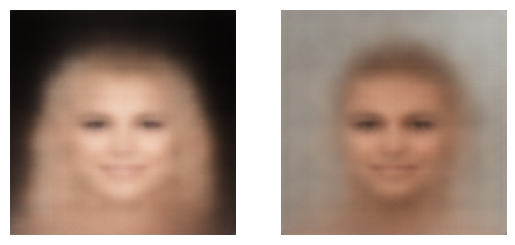

Epoch: 1; train_loss: 867514.4986; val_loss: 838392.2434


100%|██████████| 634/634 [01:51<00:00,  5.68it/s]


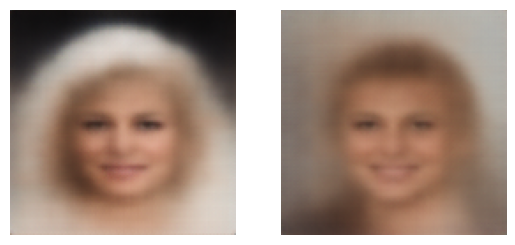

Epoch: 2; train_loss: 836999.2862; val_loss: 829828.9955


100%|██████████| 634/634 [01:42<00:00,  6.18it/s]


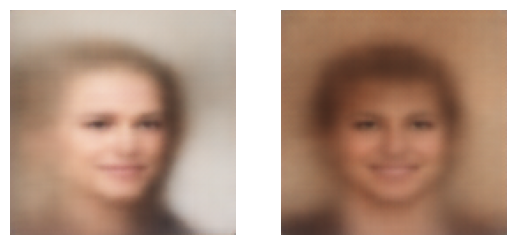

Epoch: 3; train_loss: 825894.4861; val_loss: 820550.5492


100%|██████████| 634/634 [01:44<00:00,  6.06it/s]


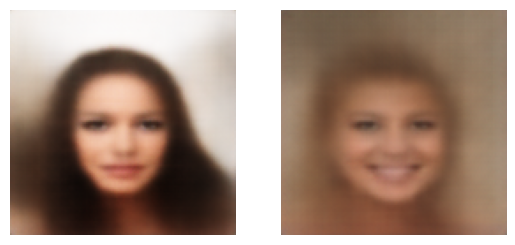

Epoch: 4; train_loss: 818548.6382; val_loss: 815697.0243


100%|██████████| 634/634 [01:49<00:00,  5.77it/s]


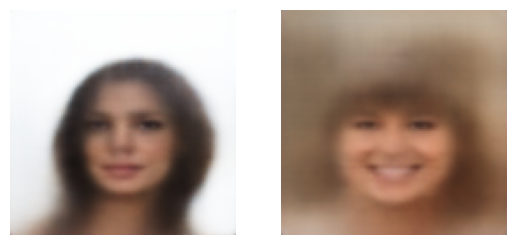

Epoch: 5; train_loss: 814442.4539; val_loss: 813371.3821


100%|██████████| 634/634 [01:58<00:00,  5.35it/s]


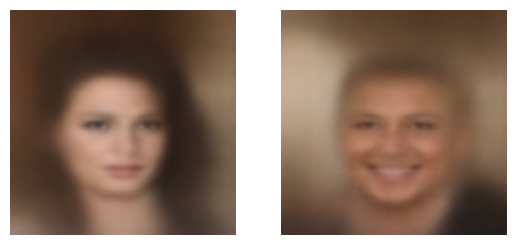

Epoch: 6; train_loss: 811402.7283; val_loss: 809322.9814


100%|██████████| 634/634 [01:47<00:00,  5.88it/s]


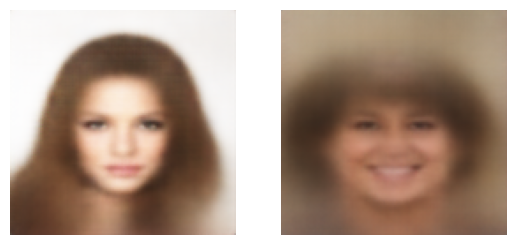

Epoch: 7; train_loss: 808899.2048; val_loss: 807758.1429


100%|██████████| 634/634 [01:44<00:00,  6.05it/s]


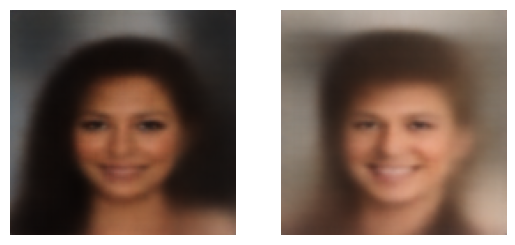

Epoch: 8; train_loss: 807162.0393; val_loss: 805927.9074


100%|██████████| 634/634 [01:43<00:00,  6.14it/s]


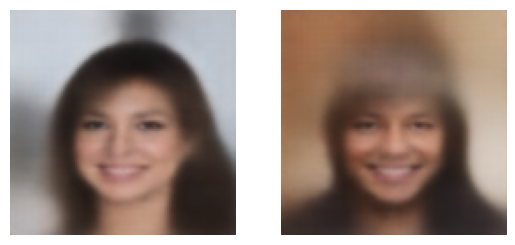

Epoch: 9; train_loss: 805707.4645; val_loss: 805535.3437


100%|██████████| 634/634 [02:13<00:00,  4.74it/s]


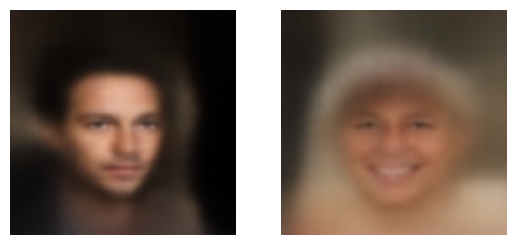

Epoch: 10; train_loss: 804264.2579; val_loss: 804140.2076


100%|██████████| 634/634 [02:00<00:00,  5.27it/s]


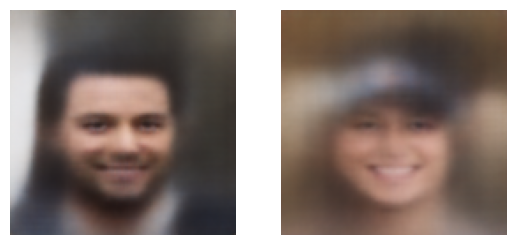

Epoch: 11; train_loss: 802789.7453; val_loss: 802409.9063


100%|██████████| 634/634 [01:56<00:00,  5.45it/s]


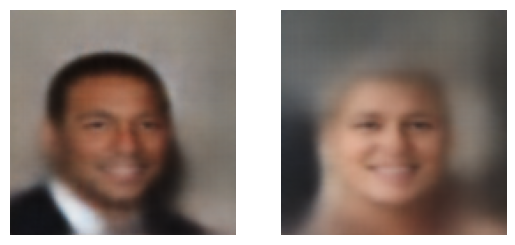

Epoch: 12; train_loss: 801922.0881; val_loss: 803933.0310


100%|██████████| 634/634 [01:49<00:00,  5.77it/s]


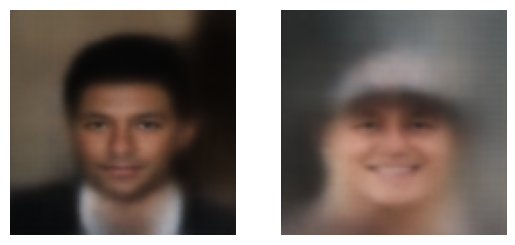

Epoch: 13; train_loss: 800791.1452; val_loss: 800916.2145


100%|██████████| 634/634 [01:48<00:00,  5.85it/s]


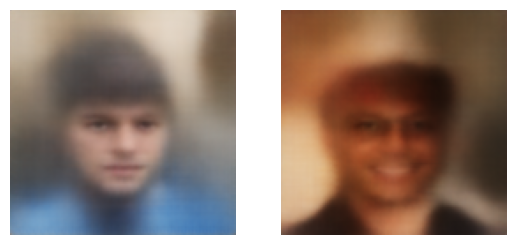

Epoch: 14; train_loss: 799814.6409; val_loss: 800234.5040


100%|██████████| 634/634 [01:58<00:00,  5.36it/s]


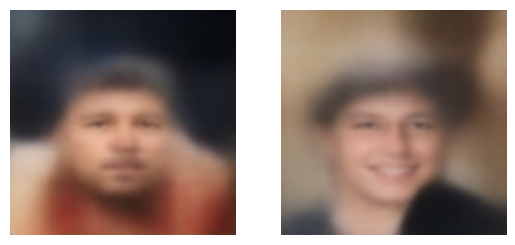

Epoch: 15; train_loss: 799064.6045; val_loss: 799664.6382


In [441]:
history = train(model, train_dl, val_dl, loss_function, perceptual_loss, optimizer, 15, device)

In [442]:
def output_metrics(history, metric):
  plt.plot(history[f"train_{metric}"], label="train set")
  plt.plot(history[f"val_{metric}"], label="validation set")
  plt.legend()
  plt.show()


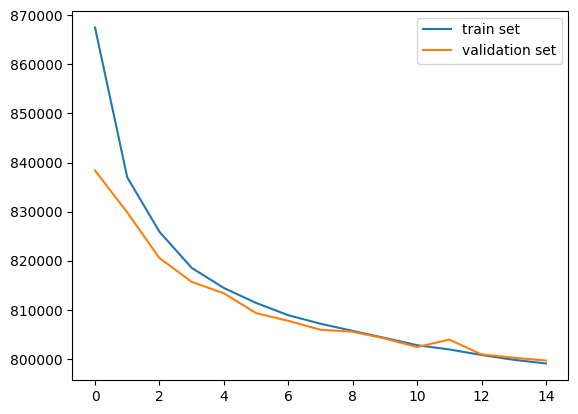

In [443]:
output_metrics(history, "loss")

In [444]:
dataframe.columns

Index(['image_id', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs',
       'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair',
       'Double_Chin', 'Eyeglasses', 'Gray_Hair', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

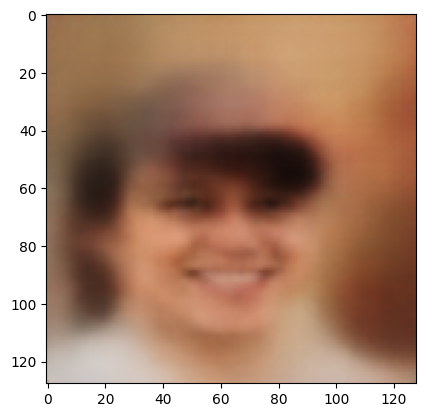

In [463]:
y = [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
y = torch.tensor(y, dtype=torch.float32)
y = y.to(device)
y = y.unsqueeze(0)
z = torch.randn(1, 128).to(device)

res = model.sample(z, y)
plt.imshow(res)

In [453]:
0 == 0

True

In [464]:
torch.save(model.state_dict(), "face_generator_VAE_08.pt")

In [ ]:
# link = "/kaggle/input/weights-77/face_generator_VAE_07.pt"
# model.load_state_dict(torch.load(link, map_location=device))

torch.Size([1, 32]) torch.Size([1, 128])


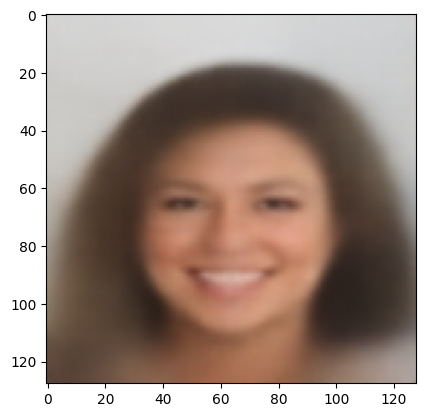

In [466]:
_, y = test_data[2]
y = y.to(device)
y = y.unsqueeze(0)
z = torch.randn(1, 128).to(device)

print(y.shape, z.shape)
res = model.sample(z, y)
plt.imshow(res)

torch.Size([1, 32]) torch.Size([1, 128])


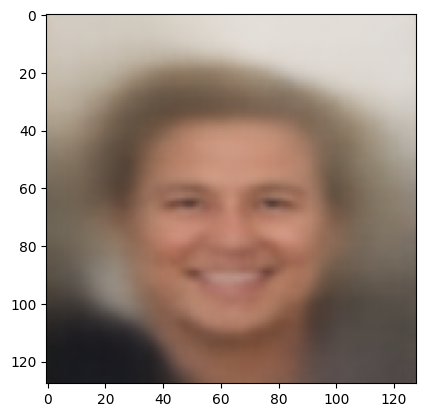

In [467]:
_, y = test_data[32]
y = y.to(device)
y = y.unsqueeze(0)
z = torch.randn(1, 128).to(device)

print(y.shape, z.shape)
res = model.sample(z, y)
plt.imshow(res)

torch.Size([1, 32]) torch.Size([1, 128])


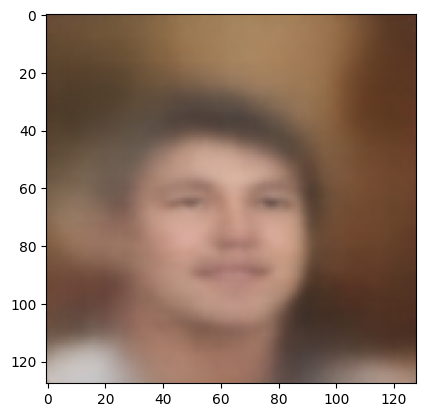

In [468]:
_, y = train_data[313]
y = y.to(device)
y = y.unsqueeze(0)
z = torch.randn(1, 128).to(device)

print(y.shape, z.shape)
res = model.sample(z, y)
plt.imshow(res)

In [469]:
from sklearn.manifold import TSNE

def visualize_latent_space_tsne(model, data_loader, device, n_samples=1000):
    model.eval()
    zs = []
    labels = []

    with torch.no_grad():
        for x, y in tqdm(data_loader):
            x = x.to(device)
            _, mu, _ = model(x, y)
            zs.append(mu.cpu())
            labels.append(torch.argmax(y, dim=1).cpu())


            
            if len(zs) * x.size(0) >= n_samples:
                break

    zs = torch.cat(zs, dim=0).cpu().numpy()
    labels = torch.cat(labels, dim=0).cpu().numpy()

    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    zs_2d = tsne.fit_transform(zs)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(zs_2d[:, 0], zs_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class')
    plt.title("t-SNE projection of VAE latent space")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()


  1%|          | 31/2533 [00:04<05:53,  7.09it/s]


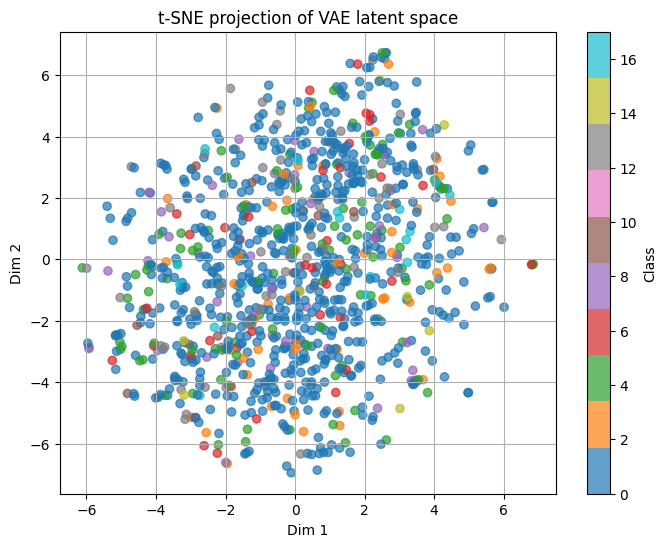

In [470]:
visualize_latent_space_tsne(model, train_dl, device, n_samples=1000)

In [ ]:
import torch
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Допустим, model - обученный VAE, device - cpu или gpu
# dataloader - загрузчик данных для визуализации

model.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for x, y in tqdm(test_dl):
        x = x.to(device)
        _, mu, logvar = model(x, y)  # метод encode возвращает параметры латентного распределения
        # Обычно берем mu как стабильное представление
        latent_vectors.append(mu.cpu())
        labels.append(torch.argmax(y, dim=1))

latent_vectors = torch.cat(latent_vectors, dim=0).cpu().numpy()
labels = torch.cat(labels, dim=0).cpu().numpy()

# Применяем UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(latent_vectors)

# Визуализируем
plt.figure(figsize=(10,7))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('UMAP проекция латентного пространства VAE')
plt.show()


In [14]:
import torch
from torch import nn 
import torch.nn.functional as F 

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # 3, 128, 128
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.bnorm1 = nn.BatchNorm2d(32)
        # 32, 64, 64
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        # self.bnorm2 = nn.BatchNorm2d(64)
        # 64, 32, 32
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1)
        # self.bnorm3 = nn.BatchNorm2d(128)
        # 128, 16, 16
        self.conv4 = nn.Conv2d(128, 128, 4, 2, 1)
        # self.bnorm4 = nn.BatchNorm2d(128)
        # 128, 8, 8
        self.conv5 = nn.Conv2d(128, 256, 4, 2, 1)
        self.bnorm5 = nn.BatchNorm2d(256)
        # 256, 4, 4
        self.conv6 = nn.Conv2d(256, 512, 4, 2, 1)
        self.bnorm6 = nn.BatchNorm2d(512)
        # 512, 2, 2

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(512 * 2 * 2, 512)
        self.dropout = nn.Dropout(0.4)
        self.linear2 = nn.Linear(512, 1)

    def forward(self, x):
        out = F.leaky_relu(self.bnorm1(self.conv1(x)))
        out = F.leaky_relu(self.conv2(out))
        out = F.leaky_relu(self.conv3(out))
        out = F.leaky_relu(self.conv4(out))
        out = F.leaky_relu(self.bnorm5(self.conv5(out)))
        out = F.leaky_relu(self.bnorm6(self.conv6(out)))

        out = self.flatten(out)
        out = self.dropout(F.leaky_relu(self.linear1(out)))
        out = self.linear2(out)

        return out

    def predict(self, x):
        self.eval()

        if len(x.shape) == 3:
            x = x.unsqueeze(0)

        with torch.no_grad():
            out = self.forward(x)
            
        res = torch.sigmoid(out)
        res = int(res.item() >= 0.5)
       
        return res 



In [25]:
model = Discriminator()
tensor = torch.randn(1, 3, 128, 128)
res = model.predict(tensor)
res

1